## Leitura dos dados vindos da API do fogo cruzado

In [150]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open('../data/occurrences_2025-01-01_2025-05-31_city_8f3a026f-2fc4-419c-9918-f0684a2abbec_page_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data['data'])

### Ocorrências mês X ações policiais

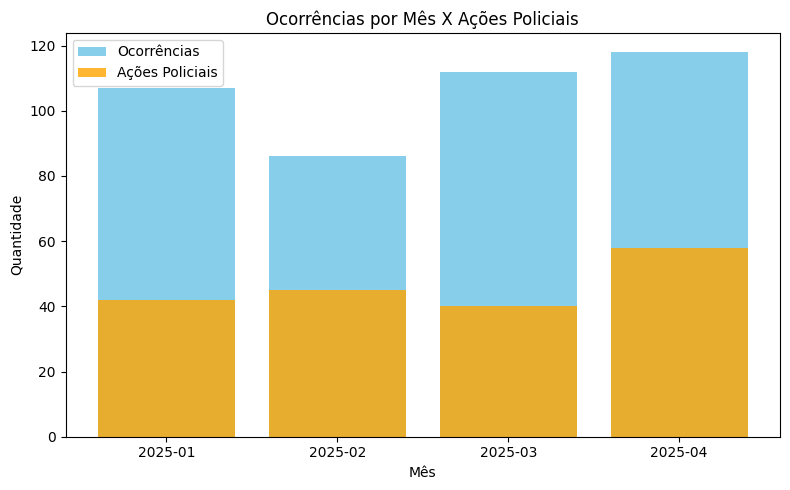

In [ ]:
ocorrencias_mes = df.groupby('month').agg(
  count=('id', 'count'),
  police_action=('policeAction', 'sum')
).reset_index()

ocorrencias_mes = ocorrencias_mes[ocorrencias_mes['month'] != pd.Period('2025-05', freq='M')]

plt.figure(figsize=(8, 5))
plt.bar(ocorrencias_mes['month'].astype(str), ocorrencias_mes['count'], label='Ocorrências', color='skyblue')
plt.bar(ocorrencias_mes['month'].astype(str), ocorrencias_mes['police_action'], label='Ações Policiais', color='orange', alpha=0.8)
plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.title('Ocorrências por Mês X Ações Policiais')
plt.legend()
plt.tight_layout()
plt.show()


### Horário com maiores indíces de ocorrências

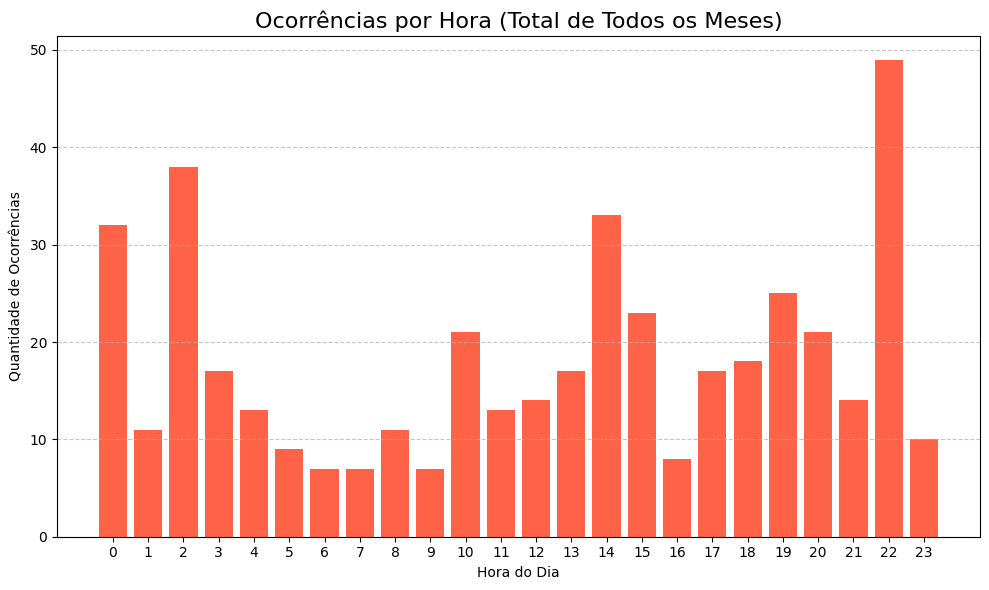

In [153]:
if 'hour' not in df.columns:
	df['hour'] = df['date'].dt.hour

hourly_total = df.groupby('hour').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.bar(hourly_total['hour'], hourly_total['count'], color='tomato')
plt.title('Ocorrências por Hora (Total de Todos os Meses)', fontsize=16)
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Ocorrências')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Os 20 bairros com maiores indices de ocorrências

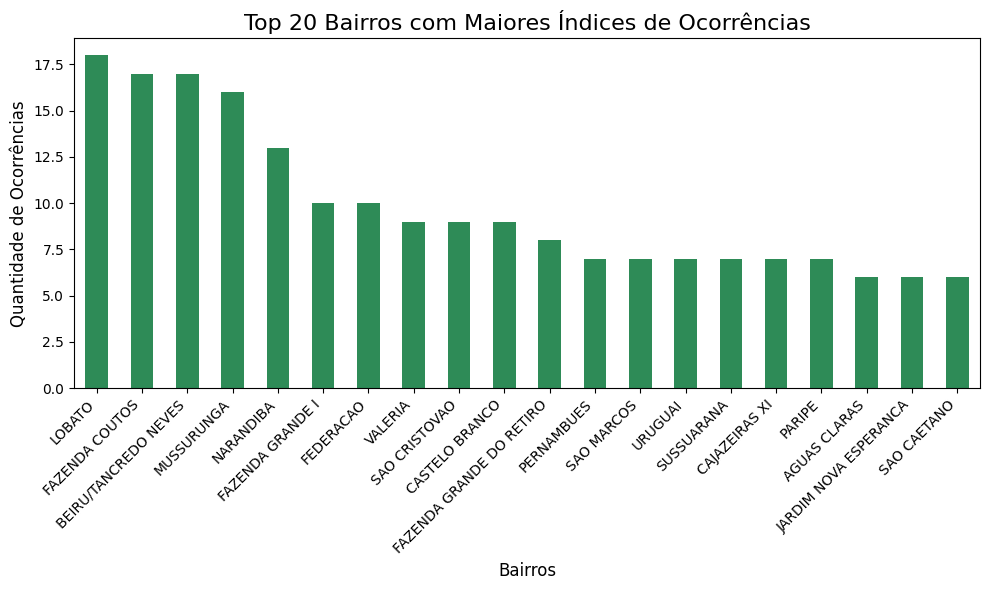

In [154]:
df['nome_bairro'] = df['neighborhood'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)

top_bairros = df['nome_bairro'].value_counts().head(20)

plt.figure(figsize=(10, 6))
ax = top_bairros.plot(kind='bar', color='seagreen')
plt.title('Top 20 Bairros com Maiores Índices de Ocorrências', fontsize=16)
plt.xlabel('Bairros', fontsize=12)
plt.ylabel('Quantidade de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()